In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm # import statsmodels 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import itertools

%matplotlib inline

In [2]:
df = pd.read_csv("USvideos.csv")
df.shape

(19772, 16)

In [3]:
def make_null_count_df(df):
    feature_name = []
    feature_null_count = []
    for i in df.columns:
        feature_name.append(i)
        feature_null_count.append(sum(df[i].isnull()))

    feature_name = pd.Series(feature_name)
    feature_null_count = pd.Series(feature_null_count)
    null_count_df = pd.concat([feature_name, feature_null_count], axis = 1)
    null_count_df.columns = ['feature_name', 'null_count']
    print("Generating plot showing distribution of nulls among all variables")
    plt.plot(np.sort(null_count_df.null_count))
    plt.title("Null Count over # of Variables")
    plt.xlabel("Number of Variables")
    plt.ylabel("Count of Nulls")
    return null_count_df

In [7]:
make_null_count_df(df)

Generating plot showing distribution of nulls among all variables


,feature_name,null_count
0,video_id,0
1,trending_date,0
2,title,0
3,channel_title,0
4,category_id,0
5,publish_time,0
6,tags,0
7,views,0
8,likes,0
9,dislikes,0


In [8]:
#THE THOR
# outcome 
# n number of variables 
# normalized residuals 
# no correlation (vif < 0.5)
# best adjusted R2 

(array([1.9525e+04, 1.7400e+02, 4.0000e+01, 1.6000e+01, 2.0000e+00,
        6.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([5.49000000e+02, 1.49381068e+07, 2.98756646e+07, 4.48132224e+07,
        5.97507802e+07, 7.46883380e+07, 8.96258958e+07, 1.04563454e+08,
        1.19501011e+08, 1.34438569e+08, 1.49376127e+08]),
 <a list of 10 Patch objects>)

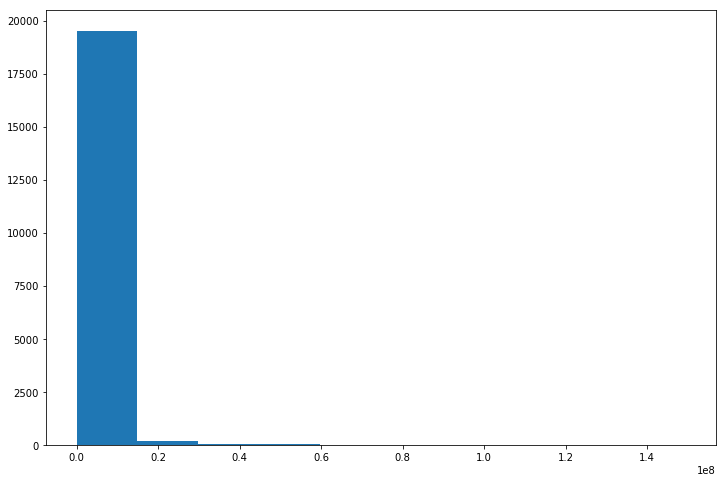

In [17]:
plt.figure(figsize=(12,8))
plt.hist(df["views"])

In [44]:
X = df[["dislikes","likes","comment_count"]]
y = df["views"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 2.222e+04
Date:                Fri, 23 Feb 2018   Prob (F-statistic):               0.00
Time:                        23:35:42   Log-Likelihood:            -3.1649e+05
No. Observations:               19772   AIC:                         6.330e+05
Df Residuals:                   19769   BIC:                         6.330e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
dislikes         62.7014      0.821     76.367      0.000      61.092      64.311
likes            29.2824      0.156    187.632      0.000      28.977      29.588
comment_count   -75.3080      1.161    -64.890      0.000     -77.583     -73.033
==============================================================================
Omnibus:                    30017.678   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28608276.085
Skew:                           9.208   Prob(JB):                         0.00
Kurtosis:                     188.436   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [78]:
[s for s in [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] if s > 5]

[6.820893234964102]

In [46]:
vif.round(1)

,VIF Factor,features
0,4.3,dislikes
1,2.4,likes
2,6.8,comment_count


In [56]:
#test normalcy 
print(stats.normaltest(model.resid)[1])

0.0


In [72]:
stuff = ["dislikes","likes","comment_count"]
lst = []
for L in range(0, len(stuff)+1):    
    for subset in itertools.combinations(stuff, L):
        lst.append([s for s in subset])

In [73]:
lst

[[],
 ['dislikes'],
 ['likes'],
 ['comment_count'],
 ['dislikes', 'likes'],
 ['dislikes', 'comment_count'],
 ['likes', 'comment_count'],
 ['dislikes', 'likes', 'comment_count']]

In [83]:
features_to_save = []
for i in lst:
    print(i)
    if (len(i) > 0):
        print("Regressing")
        X_subset = X[i]
        model = sm.OLS(y, X_subset).fit()
        p_value = stats.normaltest(model.resid)[1]
        if (p_value > 0.5):
            print("P-Value is big enough")
            above_5_vif = [s for s in [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])] if s > 5]
            if (len(above_5_vif)) == 0:
                print("Model passed, getting features")
                features_to_save.append(X_subset.columns)
                

[]
['dislikes']
Regressing
['likes']
Regressing
['comment_count']
Regressing
['dislikes', 'likes']
Regressing
['dislikes', 'comment_count']
Regressing
['likes', 'comment_count']
Regressing
['dislikes', 'likes', 'comment_count']
Regressing


In [80]:
#this list gives you a list of all features that passed, it should be a nested loop.
features_to_save

[]